# Sharpe Ratio and Optimal Position

## Imports

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random

## Generating Example Image for the Lecture

In [44]:
# Parameters for the two Gaussian distributions
mean1, sigma1 = 8, 2
mean2, sigma2 = 4, 0.5
mean3, sigma3 = mean2*2, sigma2*2
mean4, sigma4 = mean1/4.0, sigma1/4.0

# Create x values
x = np.linspace(0, 12, 1000)

# Gaussian formulas
gaussian1 = (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean1) / sigma1) ** 2)
gaussian2 = (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean2) / sigma2) ** 2)
gaussian3 = (1 / (sigma3 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean3) / sigma3) ** 2)
gaussian4 = (1 / (sigma4 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean4) / sigma4) ** 2)

# Plot the two distributions
plt.figure(figsize=(8, 5))
plt.plot(x, gaussian1, label=f'μ={mean1}, σ={sigma1}', color = 'b', linewidth = 4)
plt.plot(x, gaussian2, label=f'μ={mean2}, σ={sigma2}', color = 'r', linewidth = 4)
plt.plot(x, gaussian3, label=f'μ={mean3}, σ={sigma3}', color = 'r', linewidth = 8, alpha = 0.15)
plt.plot(x, gaussian4, label=f'μ={mean4}, σ={sigma4}', color = 'b', linewidth = 8, alpha = 0.15)
plt.title('Distributions of Returns')
plt.xlabel('Returns / Profits')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

dpi = 300
fig_width = 2560 / dpi
fig_height = 1444 / dpi

#plt.show()
plt.savefig('gaussians.png', dpi=dpi)
plt.close()

## Numerical Simulation

Function taking a numpy array of returns / profits and calculating Sharpe ratio.

In [188]:
def get_sharpe(vals):
    return np.mean(vals) / np.std(vals)

A function generating a random number from a distribution given by its mean, standard deviation and shape. Shape variable can be either 'n' (stands for "normal" distribution) or 'u' (stands for "uniform" distribution).

In [189]:
def get_val(mu, sigma, shape):
    if shape == 'n':
        return np.random.normal(mu, sigma)
    if shape == 'u':
        return np.random.uniform(mu - sigma*sqrt(3.0), mu + sigma*sqrt(3.0))

An example of usage.

In [190]:
get_val(10.0, 0.1, 'u')

10.039730775799644

We will conduct many experiments. For each experiment, we will generate a unique (experiment-specific) set of probability distributions. At each step within a given experiment, we will randomly select one distribution from this set. The set will remain fixed throughout the experiment. In other words, each experiment uses its own specific process for generating price changes.

In [191]:
rng = np.random.default_rng()

In [192]:
MU_SCALE = 0.5
SIGMA_MIN, SIGMA_MAX = 0.1, 1.0

def generate_distributions(rng, n_distr):
    return [
        (rng.normal() * MU_SCALE,
         rng.uniform(SIGMA_MIN, SIGMA_MAX),
         rng.choice(['n', 'u']))
        for _ in range(n_distr)
    ]

An example of usage:

In [194]:
distributions = generate_distributions(rng, n_distr = 10)
for distrib in distributions:
    print(distrib)

(-0.3513643631948779, 0.10085330347177501, 'u')
(0.015482746781419804, 0.4583392953605133, 'u')
(-0.19849643714321835, 0.7690536146668818, 'u')
(0.17926176679946815, 0.14997360630490494, 'n')
(-0.13415099244784748, 0.6658491074818701, 'n')
(-0.38146064534716423, 0.13144264778658432, 'u')
(0.3804999754778809, 0.5163148736425892, 'n')
(0.31263202136165436, 0.4438136658542514, 'u')
(0.2698360404539575, 0.5140435153044925, 'n')
(0.1723725343961258, 0.8840901803959437, 'n')


The following function runs a single experiment. For each of the n_steps steps, it does the following: pick one distribution from the experiment-specific set of distributions, then grab its mean (mu) and standard deviation (sigma). Using these values, calculate two positions — one with the “wrong” formula and one with the “correct” one. Next, draw a random price change from the chosen distribution and multiply it by each position to get two profit values. In the end, the function returns the profits for both ways to calculate the position.

In [195]:
def simulate_profits(rng, distribs, n_steps):
    profits_1 = np.empty(n_steps)
    profits_2 = np.empty(n_steps)
    for i in range(n_steps):
        mu, sigma, shape = distribs[rng.integers(len(distribs))]
        pos_1 = mu / sigma**2
        pos_2 = mu / (sigma**2 + mu**2)
        change = get_val(mu, sigma, shape)
        profits_1[i] = change * pos_1
        profits_2[i] = change * pos_2
    return profits_1, profits_2

Here is where we finally run the experiments. In each experiment, we end up with two Sharpe ratios: one from using the incorrect method to calculate the position, and the other from using the correct formula for the optimal position.

In [196]:
rng = np.random.default_rng()
n_experiments = 10_000
n_steps = 10_000

sharpes_1 = np.empty(n_experiments)
sharpes_2 = np.empty(n_experiments)

for exp_ind in range(n_experiments):
    distribs = generate_distributions(rng, rng.integers(5, 11))
    p1, p2 = simulate_profits(rng, distribs, n_steps)
    sharpes_1[exp_ind] = get_sharpe(p1)
    sharpes_2[exp_ind] = get_sharpe(p2)

## Visualizing Results

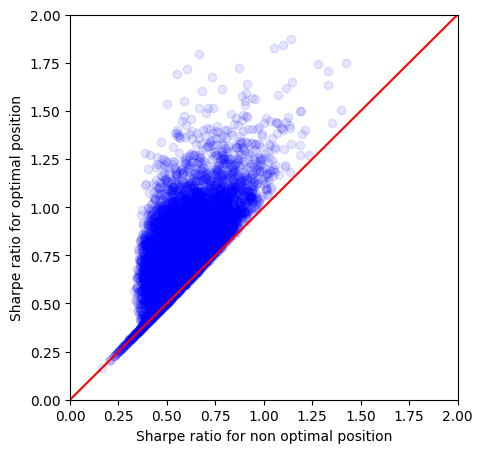

In [199]:
ls = [0.0, 2.0]
plt.figure(figsize = (5,5))
plt.xlim(ls)
plt.ylim(ls)
plt.xlabel('Sharpe ratio for non optimal position')
plt.ylabel('Sharpe ratio for optimal position')
plt.scatter(sharpes_1, sharpes_2, color = 'b', alpha = 0.1)
plt.plot(ls, ls, color = 'r')
plt.show()

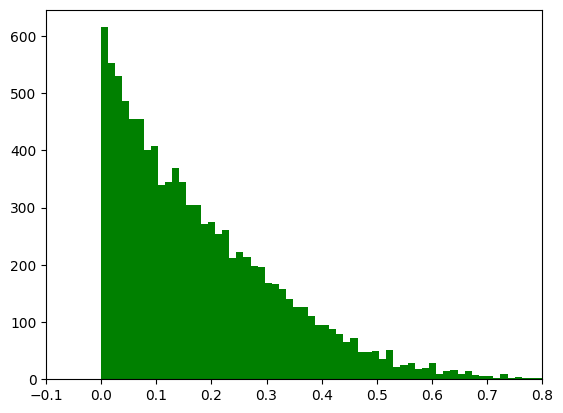

In [183]:
plt.figure()
plt.xlim([-0.1, 0.8])
plt.hist(sharpes_2 - sharpes_1, bins=100, color = 'g', alpha = 1.0)
plt.show()